In [ ]:
# --- BLOCK 1: INSTALLATION & IMPORTS ---
!pip install "numpy<2.1" "pandas==2.2.2" pandapower torch_geometric

import pandapower as pp

import pandapower.networks as nw

import numpy as np

import torch

import torch.nn.functional as F

from torch_geometric.data import Data

from torch_geometric.loader import DataLoader

from torch_geometric.nn import TAGConv

import copy

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pandapower to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 2.9 MB/s eta 0:00:00


In [ ]:

# 1. DATA GENERATION (Fixed Inputs)

def generate_proxy_data(n_samples=2000):

    dataset_list = []

    base_net = nw.case33bw()

    der_buses = [10, 20, 30]



    # Topology (Static)

    from_bus = torch.tensor(base_net.line['from_bus'].values, dtype=torch.long)

    to_bus = torch.tensor(base_net.line['to_bus'].values, dtype=torch.long)

    edge_index = torch.stack([torch.cat([from_bus, to_bus]), torch.cat([to_bus, from_bus])], dim=0)



    print(f"Generating {n_samples} Physics-Consistent samples...")



    for _ in range(n_samples):

        net = copy.deepcopy(base_net)



        # A. Randomize Scenario

        scale = np.random.uniform(0.5, 1.5)

        net.load['p_mw'] *= scale

        net.load['q_mvar'] *= scale



        # B. Randomize Dispatch (INPUT Version)

        dispatch = np.random.uniform(0.0, 1.0, size=len(der_buses))

        for i, bus in enumerate(der_buses):

            pp.create_sgen(net, bus, p_mw=dispatch[i], q_mvar=0.0)



        # C. Run Physics Solver (Ground Truth)

        try:

            pp.runpp(net, algorithm='nr')

        except:

            continue



        # D. Construct Input X (Load + Generation)

        # We merge Load (Consumption) and Gen (Production) into "Net Power"

        # P_net = P_gen - P_load

        p_node = np.zeros(len(net.bus))

        q_node = np.zeros(len(net.bus))



        # Fill Loads (Negative Power)

        p_node[net.load.bus.values] -= net.load.p_mw.values

        q_node[net.load.bus.values] -= net.load.q_mvar.values



        # Fill Gens (Positive Power)

        p_node[der_buses] += dispatch



        # Normalize inputs

        x = torch.stack([

            torch.tensor(p_node / 5.0, dtype=torch.float), # Net Active Power

            torch.tensor(q_node / 5.0, dtype=torch.float), # Net Reactive Power

            torch.zeros(len(net.bus)) # Placeholder or Type flag

        ], dim=1)



        # Mark generator buses in the 3rd column so AI knows where they are

        x[der_buses, 2] = 1.0



        # E. Construct Target Y (Voltage Only)



        v = torch.tensor(net.res_bus['vm_pu'].values, dtype=torch.float).unsqueeze(1)

        theta = torch.tensor(np.radians(net.res_bus['va_degree'].values), dtype=torch.float).unsqueeze(1)



        y = torch.cat([v, theta], dim=1) # [Nodes, 2]



        dataset_list.append(Data(x=x, edge_index=edge_index, y=y))



    return dataset_list



# 2. MODEL (Proxy Solver)

class ProxySolverGNN(torch.nn.Module):

    def __init__(self):

        super().__init__()

        # Deeper model to capture complex physics

        self.conv1 = TAGConv(3, 256, K=3)

        self.conv2 = TAGConv(256, 128, K=3)

        self.conv3 = TAGConv(128, 64, K=2)

        self.lin = torch.nn.Linear(64, 2) # Output: V, Theta



    def forward(self, data):

        x, edge_index = data.x, data.edge_index

        x = F.leaky_relu(self.conv1(x, edge_index)) # LeakyReLU avoids dying neurons

        x = F.leaky_relu(self.conv2(x, edge_index))

        x = F.leaky_relu(self.conv3(x, edge_index))

        out = self.lin(x)

        return out






Generating 5000 Physics-Consistent samples...
--- Training on 5000 samples for 300 Epochs ---
Epoch 20 | Train Loss: 0.000043 | Val Loss: 0.000041
Epoch 40 | Train Loss: 0.000048 | Val Loss: 0.000023
Epoch 60 | Train Loss: 0.000028 | Val Loss: 0.000023
Epoch 80 | Train Loss: 0.000016 | Val Loss: 0.000015
Epoch 100 | Train Loss: 0.000010 | Val Loss: 0.000009
Epoch 120 | Train Loss: 0.000009 | Val Loss: 0.000008
Epoch 140 | Train Loss: 0.000007 | Val Loss: 0.000009
Epoch 160 | Train Loss: 0.000007 | Val Loss: 0.000006
Epoch 180 | Train Loss: 0.000006 | Val Loss: 0.000006
Epoch 200 | Train Loss: 0.000005 | Val Loss: 0.000007
Epoch 220 | Train Loss: 0.000005 | Val Loss: 0.000005
Epoch 240 | Train Loss: 0.000005 | Val Loss: 0.000005
Epoch 260 | Train Loss: 0.000005 | Val Loss: 0.000005
Epoch 280 | Train Loss: 0.000005 | Val Loss: 0.000005
Epoch 300 | Train Loss: 0.000005 | Val Loss: 0.000005


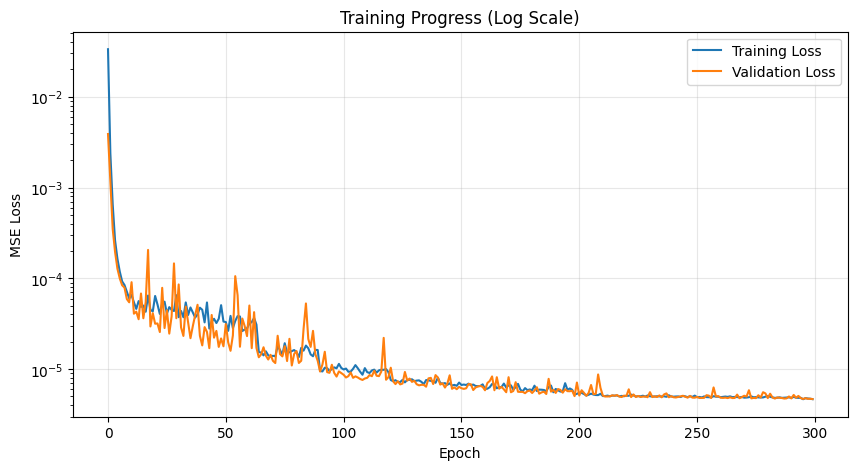

In [ ]:
# ==========================================
# 3. TRAINING LOOP
# ==========================================

# A. Dataset

dataset = generate_proxy_data(n_samples=5000)

# Split 80/20
train_size = int(len(dataset) * 0.8)
train_loader = DataLoader(dataset[:train_size], batch_size=32, shuffle=True)
test_loader = DataLoader(dataset[train_size:], batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ProxySolverGNN().to(device)


# B. Optimizer & Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler (Corrected for PyTorch 2.2+)
# removed 'verbose=True' to fix the error
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)



print(f"--- Training on {len(dataset)} samples for 300 Epochs ---")

train_losses = []
val_losses = []

for epoch in range(1, 301):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out, batch.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    # Update the Learning Rate based on Validation Loss
    scheduler.step(avg_val_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.yscale('log') # Log scale helps see small improvements
plt.title("Training Progress (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Generating comprehensive visual report...


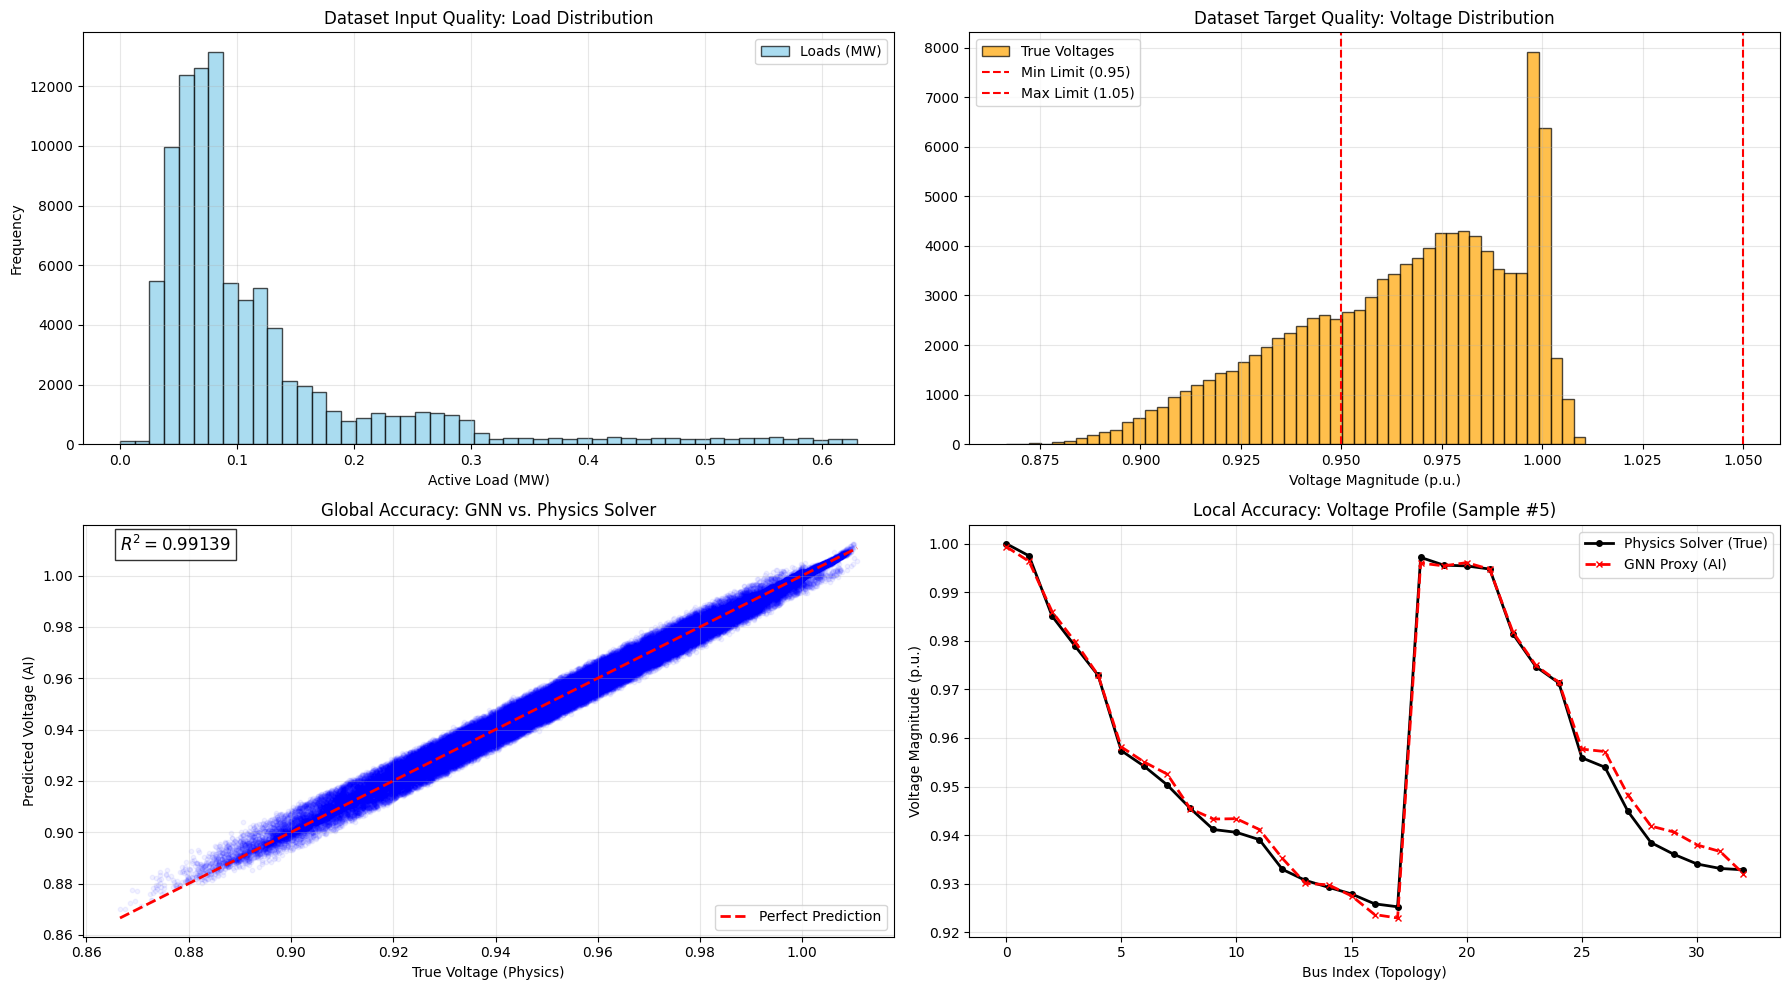


FINAL MODEL REPORT CARD
1. Overall Accuracy (R2): 0.99139 (Target: > 0.99)
2. Mean Squared Error:    0.00000682 (Target: < 0.0001)
3. Data Check: Min Voltage in dataset was 0.8666 p.u.


In [ ]:
# ==========================================
# 5.VISUALIZATION
# ==========================================
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # Optional, for nicer histograms

def advanced_visualization(model, dataset, device):
    print("Generating comprehensive visual report...")

    # --- PREPARE DATA ---
    # data from the TEST SET (last 200 samples)

    test_subset = dataset[1800:]
    loader_viz = DataLoader(test_subset, batch_size=1, shuffle=False)

    all_true_v, all_pred_v = [], []
    all_loads = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(loader_viz):
            batch = batch.to(device)
            out = model(batch)

            # Store Output (Voltages)
            all_true_v.extend(batch.y[:, 0].cpu().numpy())
            all_pred_v.extend(out[:, 0].cpu().numpy())

            # Store Input (Loads) for checking dataset quality
            # Recall: x[:, 0] is Net Power. Negative values are Loads.
            net_p = batch.x[:, 0].cpu().numpy()
            loads = net_p[net_p < 0] * -5.0 # Un-normalize back to MW
            all_loads.extend(loads)


            if i == 5:
                sample_true = batch.y.cpu().numpy()
                sample_pred = out.cpu().numpy()

    # --- PLOTTING ---
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2)

    # PLOT 1: Dataset Reality Check (Histograms)
    # Proves your data isn't "broken" (e.g., all zeros or unphysical values)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(all_loads, bins=50, color='skyblue', edgecolor='black', alpha=0.7, label='Loads (MW)')
    ax1.set_title("Dataset Input Quality: Load Distribution")
    ax1.set_xlabel("Active Load (MW)")
    ax1.set_ylabel("Frequency")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # PLOT 2: Target Voltage Distribution
    # Proves the physics solver produced valid voltages (should be bell-shaped near 1.0)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.hist(all_true_v, bins=50, color='orange', edgecolor='black', alpha=0.7, label='True Voltages')
    ax2.axvline(0.95, color='r', linestyle='--', label='Min Limit (0.95)')
    ax2.axvline(1.05, color='r', linestyle='--', label='Max Limit (1.05)')
    ax2.set_title("Dataset Target Quality: Voltage Distribution")
    ax2.set_xlabel("Voltage Magnitude (p.u.)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # PLOT 3: Parity Plot
    # Shows global accuracy. Ideal = All blue dots on the red line.
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.scatter(all_true_v, all_pred_v, alpha=0.05, color='blue', s=10) # Low alpha to see density

    # Reference Line
    min_v, max_v = min(all_true_v), max(all_true_v)
    ax3.plot([min_v, max_v], [min_v, max_v], 'r--', linewidth=2, label='Perfect Prediction')

    # Calculate R2 Score
    r2 = r2_score(all_true_v, all_pred_v)
    ax3.text(min_v, max_v*0.999, f'$R^2 = {r2:.5f}$', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    ax3.set_title("Global Accuracy: GNN vs. Physics Solver")
    ax3.set_xlabel("True Voltage (Physics)")
    ax3.set_ylabel("Predicted Voltage (AI)")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # PLOT 4: Spatial Voltage Profile (Sample #5)
    # Shows local accuracy along the grid topology.
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(sample_true[:, 0], 'k-', marker='o', markersize=4, label='Physics Solver (True)', linewidth=2)
    ax4.plot(sample_pred[:, 0], 'r--', marker='x', markersize=4, label='GNN Proxy (AI)', linewidth=2)

    ax4.set_title("Local Accuracy: Voltage Profile (Sample #5)")
    ax4.set_xlabel("Bus Index (Topology)")
    ax4.set_ylabel("Voltage Magnitude (p.u.)")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- TEXT METRICS ---
    mse = np.mean((np.array(all_true_v) - np.array(all_pred_v))**2)
    print("\n" + "="*30)
    print(f"FINAL MODEL REPORT CARD")
    print("="*30)
    print(f"1. Overall Accuracy (R2): {r2:.5f} (Target: > 0.99)")
    print(f"2. Mean Squared Error:    {mse:.8f} (Target: < 0.0001)")
    print(f"3. Data Check: Min Voltage in dataset was {min(all_true_v):.4f} p.u.")
    print("="*30)

# Run the visualization
advanced_visualization(model, dataset, device)


--- Running Corrected IEEE 33-Bus Benchmark ---


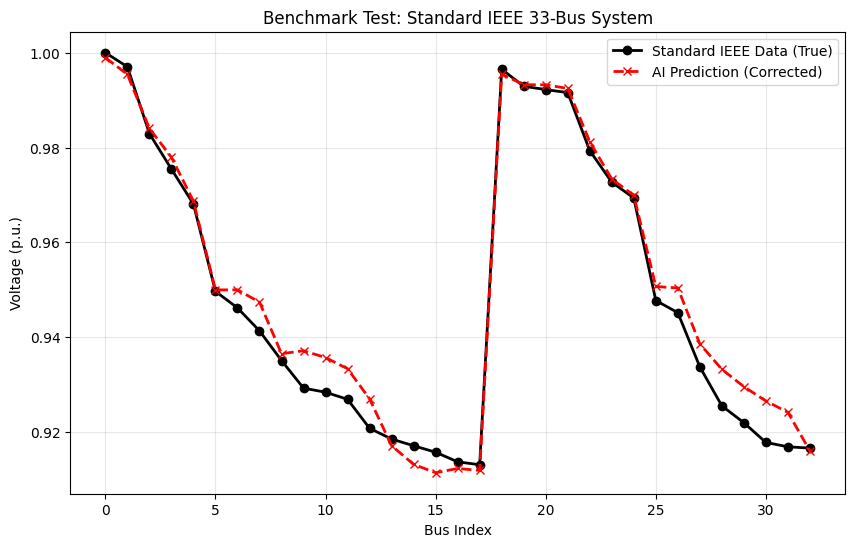

Benchmark MSE Loss: 0.00001861


In [ ]:
# ==========================================
# BENCHMARK TEST: IEEE 33-BUS STANDARD CASE
# ==========================================
def test_standard_benchmark_corrected(model, device):
    print("\n--- Running Corrected IEEE 33-Bus Benchmark ---")

    # 1. Load Standard Case
    net = nw.case33bw()
    der_buses = [10, 20, 30] # The specific buses your model knows

    # 2. Topology
    from_bus = torch.tensor(net.line['from_bus'].values, dtype=torch.long)
    to_bus = torch.tensor(net.line['to_bus'].values, dtype=torch.long)
    edge_index = torch.stack([torch.cat([from_bus, to_bus]), torch.cat([to_bus, from_bus])], dim=0)

    # 3. Inputs
    p_node = np.zeros(len(net.bus))
    q_node = np.zeros(len(net.bus))

    # Fill standard loads (Negative)
    p_node[net.load.bus.values] -= net.load.p_mw.values
    q_node[net.load.bus.values] -= net.load.q_mvar.values

    # Construct X

    gen_flags = torch.zeros(len(net.bus))

    gen_flags[der_buses] = 1.0

    x = torch.stack([
        torch.tensor(p_node / 5.0, dtype=torch.float),
        torch.tensor(q_node / 5.0, dtype=torch.float),
        gen_flags
    ], dim=1)

    data = Data(x=x, edge_index=edge_index).to(device)

    # 4. Predict
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred_v = out[:, 0].cpu().numpy()

    pp.runpp(net)
    true_v = net.res_bus['vm_pu'].values

    # 4. Plot

    plt.figure(figsize=(10, 6))
    plt.plot(true_v, 'k-o', label='Standard IEEE Data (True)', linewidth=2)
    plt.plot(pred_v, 'r--x', label='AI Prediction (Corrected)', linewidth=2)
    plt.title("Benchmark Test: Standard IEEE 33-Bus System")
    plt.xlabel("Bus Index")
    plt.ylabel("Voltage (p.u.)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    mse = np.mean((true_v - pred_v)**2)
    print(f"Benchmark MSE Loss: {mse:.8f}")

test_standard_benchmark_corrected(model, device)